In [27]:
# 데이터 다루는 가장 기본적인 library
import pandas as pd
import numpy as np
import os, pickle

## Data 위치 확인

In [28]:
!pwd

/home/M2017017/KKBox/notebook


In [29]:
!ls ../tut_data/

answer_final.pkl  members_v3.csv.7z	 transaction_summary.pkl
answer.pkl	  train.csv		 user_logs_small.csv
log_summary.pkl   train.csv.7z
member.pkl	  transaction_small.pkl


In [30]:
! rm ../tut_data/train.csv

In [31]:
!7z x -t7z ../tut_data/train.csv.7z -y -o../tut_data


7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,48 CPUs)

Processing archive: ../tut_data/train.csv.7z

Extracting  train.csv

Everything is Ok

Size:       46667771
Compressed: 33563098


In [32]:
!man 7z

7z(1)                       General Commands Manual                      7z(1)

NNAAMMEE
       7z - A file archiver with highest compression ratio

SSYYNNOOPPSSIISS
       77zz [[aaddeellttuuxx]] [[--]] [[SSWWIITTCCHH]] <<AARRCCHHIIVVEE__NNAAMMEE>> <<AARRGGUUMMEENNTTSS>>......

DDEESSCCRRIIPPTTIIOONN
       7-Zip  is  a file archiver with the highest compression ratio. The pro‐
       gram supports 7z (that implements LZMA compression  algorithm),  LZMA2,
       XZ,  ZIP,  Zip64,  CAB,  RAR  (if  the  non-free  p7zip-rar  package is
       installed), ARJ, GZIP, BZIP2, TAR,  CPIO,  RPM,  ISO,  most  filesystem
       images  and  DEB  formats.  Compression  ratio  in the new 7z format is
       30-50% better than ratio in ZIP format.

       7z uses plugins to handle archives.

FFUUNNCCTTIIOONN LLEETTTTEERRSS
       aa      Add

       dd      Delete

       ee      Extract

       ll      List

In [33]:
!ls ../tut_data/

answer_final.pkl  members_v3.csv.7z	 transaction_summary.pkl
answer.pkl	  train.csv		 user_logs_small.csv
log_summary.pkl   train.csv.7z
member.pkl	  transaction_small.pkl


## Data loading
* 모든 데이터는 미리 준비되어 있으나, pandas 기능을 활용해 보기 위해 1개의 file만 불러옴

In [34]:
# 최초 실행시만 run
# 모두 불러오면 7.1GB
answer = pd.read_csv('../tut_data/train.csv')
#member = pd.read_csv('../tut_data/members_v3.csv')
#transaction = pd.read_csv('../tut_data/transactions_small.csv')

In [35]:
# 다음번에 사용을 위해서 pickle로 저장 (약 50초)
#pickle.dump(answer, open('../tut_data/answer.pkl', 'wb'))
#pickle.dump(member, open('../tut_data/member.pkl', 'wb'))
#pickle.dump(transaction, open('../tut_data/transaction.pkl', 'wb'))

In [36]:
del answer # (1G)
#del member #(2G)
#del transaction #(4G)

* Data를 불러오기 쉬운 format으로 저장하는 것은 중요한 일!!

## ***answer.csv***

  * 현실적으로 가장 먼저 check해야 할 것 중의 하나
  * 성능에 가장 큰 영향을 미치는 요소 중 하나
  * 현실적으로는 under sampling 혹은 up sampling으로 해결함
  



# **실습**

### load data and inspect column

In [37]:
answer = pickle.load(open('../tut_data/answer.pkl', 'rb'))
answer.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


### 건수 확인

In [38]:
# answer set ratio
answer.groupby(['is_churn']).count().reset_index()

,is_churn,msno
0,0,929460
1,1,63471


### Plot histogram

In [39]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral5, Oranges9, Viridis256
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [40]:
answer.is_churn = answer.is_churn.astype(str)
data = answer.groupby(['is_churn'])
source = ColumnDataSource(data)

p = figure(plot_height=350, x_range=data)
p.vbar(x='is_churn', top='msno_count', width=1, line_color="white", 
        source=source)

p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Churn or not"
p.yaxis.axis_label = "Count"
p.y_range.start = 0

show(p)

####  $\Rightarrow$ Severely imbalanced

* 대부분의 churn prediction에서 나타나는 현상
  - Anormaly detection에서는 unsupervised problem으로 접근하기도
  
* 데이터의 크기도 문제일테고, 따라서 분석을 위해서는 적당하게 undersampling이 필요.

* 1차적으로는 *under sampling*을 통해 answer set을 확정

## ***member dataset***

* 결국 분석은 고객 단위의 예측이 목표
* 고객은 key의 역할을 하고 있어, 여러가지 data를 merge해서 최종 분석용 data를 만들 때, 고객단위의 data를 만들어야 함
* 가장 중요한 것은 key가 unique한지 test
  - key가 unique하지 않으면, merge에 문제가 생김
  - 실제 업무에서는 시간을 낭비하는 주요 요소 중 하나임

In [41]:
member = pickle.load(open('../tut_data/member.pkl', 'rb'))
member.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


### Unique or not
  * join을 하기 위해서 unique한 key가 있어야 함

In [42]:
# Join을 하기 위해서 unique한 key가 있어야 함
a = member.shape
b = member.groupby(['msno']).count().shape
try:
    assert a[0] == b[0]
    print('key unique')
except Exception as e:
    print('key not unique')

key unique


## 전반적인 summary: Pandas

### Pandas 자료형 변환


In [43]:
member.dtypes

msno                      object
city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
dtype: object

In [44]:
member.registration_init_time = pd.to_datetime(member.registration_init_time, format='%Y%m%d')
member.registered_via = member.registered_via.astype(str)

In [45]:
member.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


In [46]:
member.dtypes

msno                              object
city                               int64
bd                                 int64
gender                            object
registered_via                    object
registration_init_time    datetime64[ns]
dtype: object

### numeric column만 summary

In [47]:
# member.describe(include = [np.number])
member.describe()

,city,bd
count,6.769473e+06,6.769473e+06
mean,3.847358e+00,9.795794e+00
std,5.478359e+00,1.792590e+01
min,1.000000e+00,-7.168000e+03
25%,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00
75%,4.000000e+00,2.100000e+01
max,2.200000e+01,2.016000e+03


### Date도 summary

In [48]:
# https://stackoverflow.com/questions/24524104/pandas-describe-is-not-returning-summary-of-all-columns
member.describe(include = 'all')

,msno,city,bd,gender,registered_via,registration_init_time
count,6769473,6.769473e+06,6.769473e+06,2339968,6769473,6769473
unique,6769473,NaN,NaN,2,18,4782
top,DVqfpHARJStwXmYq6TCypK+7yw5bPnmAejrVhvf+mfg=,NaN,NaN,male,4,2015-10-09 00:00:00
freq,1,NaN,NaN,1195355,2793213,12413
first,NaN,NaN,NaN,NaN,NaN,2004-03-26 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2017-04-29 00:00:00
mean,NaN,3.847358e+00,9.795794e+00,NaN,NaN,NaN
std,NaN,5.478359e+00,1.792590e+01,NaN,NaN,NaN
min,NaN,1.000000e+00,-7.168000e+03,NaN,NaN,NaN
25%,NaN,1.000000e+00,0.000000e+00,NaN,NaN,NaN


### Gender에 missing이 너무 많다.

Gender에 대한 정보 수집 상태를 확인할 수 있음

In [49]:
member[member['gender'].isnull()]

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
6,jNCGK78YkTyId3H3wFavcBLDmz7pfqlvCfUKf4G1Lw4=,1,0,NaN,7,2011-09-16
10,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,1,0,NaN,7,2011-09-18
15,hZia/3iyvtThD1kv6ozRjRj8T0CAz0+zUFxs3e27wo8=,1,0,NaN,9,2011-09-22
16,QlDflP89J5KChheo2sbtH++SSDY/hUDj54gkgdfE76U=,1,0,NaN,9,2011-09-22
18,GsPgdrXoV6688/0RFAwjKxQUpBB28JxK/Nx45kEpH60=,1,0,NaN,7,2011-09-24
29,ZXtW2HuuVK4aPiO10RhBWT1PmLV+bKqnFlT5bL6YhoQ=,4,0,NaN,9,2011-09-28


In [50]:
member[member['msno'] == 'jNCGK78YkTyId3H3wFavcBLDmz7pfqlvCfUKf4G1Lw4=']

,msno,city,bd,gender,registered_via,registration_init_time
6,jNCGK78YkTyId3H3wFavcBLDmz7pfqlvCfUKf4G1Lw4=,1,0,NaN,7,2011-09-16


### 총 missing된 고객의 숫자

In [51]:
member[member['gender'].isnull()].groupby('msno').count().shape[0] 
# 행의 개수

4429505

In [52]:
# 리스트 형태에서 많이 쓰이는 문법
[x**2 for x in range(10)]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [54]:
# [None]
[print('{data} = {value}'.
       format(data = x, value = pd.unique(member[x]))) 
 for x in member.columns if x not in ('msno', 'registration_init_time')]

city = [ 1  6  4  5 13 22 12 15 11  9 14  8 18 21  3  7 17 10 20 16 19]
bd = [    0    32    30    34    19    63    18    28    29    31    22    23
    21    27    47    38    36    26    58    43    33    39    24    20
    25    41    17    54    40    45    52    56    50    35    42    49
    44    48    57    37    51    60    46    59    53    16    14   104
    15    64    91    69    62    55    61    65    75   106   108    99
    68    82    95    90    67    96    77    66   -39     6    76   109
    72    13    80    93     7  1028    94   117    70     4   793   105
   923   107   112    73    87    88    86    71    81    97    85    79
   102   101    78   111     1    89    74    84   110    98  -518   -51
    12    83  1037   103   116   100    10  1025     5   220    92     9
   115     8  1039  1052  -506   938    11  -510   -36   240  1031   -43
   584   944  -958   137   -48     3  1032  -515   217     2  1820  -504
  -519   265   143   119   151   -47   689   18

[None, None, None, None]

In [53]:
# 각 셀의 라벨값들을 확인
# df[x] -> Series, df[[x]] -> df
# pass : [None] 을 없애줌 
[print('{data} = {value}'.
       format(data = x, value = pd.unique(member[x]))) 
 for x in member.columns if x not in ('msno', 'registration_init_time')]
pass

city = [ 1  6  4  5 13 22 12 15 11  9 14  8 18 21  3  7 17 10 20 16 19]
bd = [    0    32    30    34    19    63    18    28    29    31    22    23
    21    27    47    38    36    26    58    43    33    39    24    20
    25    41    17    54    40    45    52    56    50    35    42    49
    44    48    57    37    51    60    46    59    53    16    14   104
    15    64    91    69    62    55    61    65    75   106   108    99
    68    82    95    90    67    96    77    66   -39     6    76   109
    72    13    80    93     7  1028    94   117    70     4   793   105
   923   107   112    73    87    88    86    71    81    97    85    79
   102   101    78   111     1    89    74    84   110    98  -518   -51
    12    83  1037   103   116   100    10  1025     5   220    92     9
   115     8  1039  1052  -506   938    11  -510   -36   240  1031   -43
   584   944  -958   137   -48     3  1032  -515   217     2  1820  -504
  -519   265   143   119   151   -47   689   18

In [55]:
# 고객별로 최초 등록 날짜 파악
min_register = member.groupby(['msno'])[['registration_init_time']].min()

In [56]:
min_register.head()

,registration_init_time
msno,
+++4vcS9aMH7KWdfh5git6nA5fC5jjisd5H/NcM++WM=,2009-06-19
+++5EL4GxAvkaQctwqinyuJhkHEofaKoP2EMm0EoRAo=,2014-04-16
+++A5IxXtG7Qtf8jDzxPT3J2urTd5HyB316rrLG6PtU=,2014-09-21
+++EI4HgyhgcJHIPXk/VRP7bt17+2joG39T6oEfJ+tc=,2016-04-20
+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,2004-03-27


### Summary of members dataset

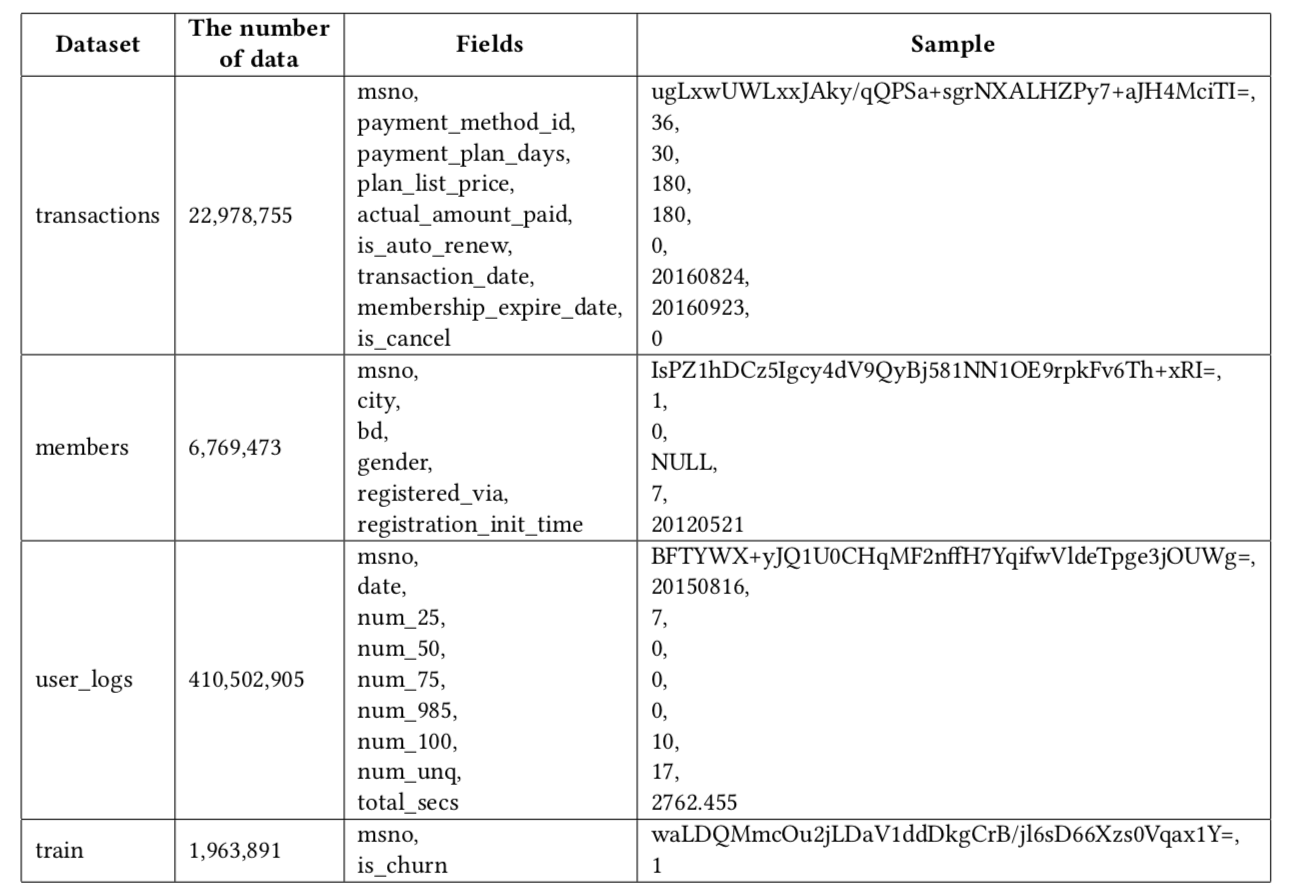
* Source: https://wsdm-cup-2018.kkbox.events/pdf/7_A_Practical_Pipeline_with_Stacking_Models_for_KKBOXs_Churn_Prediction_Challenge.pdf